In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
import torch.nn.utils as nn_utils
from tqdm.autonotebook import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr
import squidpy as sq
import numpy as np
import time
import random
import scanpy as sc
import anndata as ad
from anndata import AnnData
from squidpy.gr import spatial_neighbors,spatial_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation

/tmp/ipykernel_3652510/2058128981.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(0)

# use GPU if available
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

torch.cuda.empty_cache()

adata = sq.datasets.visium_hne_adata()

In [3]:
def run_benchmarking_experiments(X_train, Y_train, M, L, K, steps=1000, batch_size=64):
    for k in tqdm(range(len(K))):
        for m in range(len(M)):
            for l in range(len(L)):
                # make data dictionary
                exp_data = {
                    'model' :  [],
                    'Z' : [],
                    'L' : [],
                    'K': [],
                    'time' : []}
                # run model
                #idx = torch.multinomial(torch.ones(X_train.shape[0]), num_samples=M[m], replacement=False)
                model = initialize_model(M[m], L[l], K[k], X_train, Y_train, 1.0, 1.0)
                optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
                model.to(device)
                start_time = time.time()
                X_train = torch.tensor(X_train, device=device, dtype=torch.float32, requires_grad=True)
                losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=steps, E=10)
                #losses, means, scales, idxs = train_batched(model, optimizer, X_train, Y_train, device, steps=steps, E=10, batch_size=batch_size)
                end_time = time.time()
                final_time = end_time - start_time

                # update data dictionary
                exp_data['L'].append(L)
                exp_data['Z'].append(M)
                exp_data['K'].append(K)
                alg = 'NNNSF'
                exp_data['model'].append(alg)
                exp_data['time'].append(final_time)

                # make + save loss plot
                fig1, ax1 = plt.subplots()
                plt.plot(losses)
                plt.title(f"Visium Losses")
                plt.close(fig1)

                # make + save factors plot
                size=5
                #X_train = torch.tensor(X_train, device='cuda', dtype=torch.float32, requires_grad=True)
                qF, qU, pU = model.prior(X_train)
                loadings = torch.exp(qF.mean).detach().cpu().numpy()
                del qF, qU, pU
                with torch.no_grad():
                    if device.type=='cuda':
                        torch.cuda.empty_cache()
                X_train = X_train.detach().cpu().numpy()
                moran_idx, moranI = dims_autocorr(np.log(loadings).T, X_train)

                fig2, ax2 = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
                fig2.suptitle("NNNSF Factors", size=20)
                plot(X_train, loadings, moran_idx, L[l], ax=ax2, size=5, alpha=0.8)
                plt.close(fig2)

                # make + save animation
                fig3, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
                fig3.suptitle("NNNSF Factors", size=20)

                def update(iteration):
                    for ax_row in ax:
                        for element in ax_row:
                            element.cla()
                    curr_mean = means[iteration]
                    #curr_idx = idxs[iteration]
                    plot(X_train, curr_mean, moran_idx, L=10, ax=ax, size=size, alpha=0.9)

                anim = FuncAnimation(fig3, update, frames=np.arange(0, len(means), 1), interval=100)
                plt.show()
                plt.close()
                anim.save(f'.visium_K={K[k]}_Z={M[m]}_factors_anim.mp4', writer="pillow")

In [4]:
def train(model, optimizer, X, y, device, steps=200, E=10, batch_size=64, **kwargs):
    losses = []
    means = []
    scales = []
    #idxs = []
    
    for it in tqdm(range(steps)):   
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)

        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)

        logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()

        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            #idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [5]:
def initialize_model(M, L, K, X, Y, sigma=1.0, lengthscale=1.0):
    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
    kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=1.0)
    gp = VNNGP(kernel, M=M, jitter=1e-2, K=K)
    gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
    gp.mu = nn.Parameter(torch.randn((L, M)))
    gp.Z = nn.Parameter(torch.tensor(X[idx]))

    model = NSF2(gp=gp, y=Y, L=L)
    model.prior.kernel.lengthscale.requires_grad = True
    model.prior.kernel.sigma.requires_grad = False
    model.prior.Z.requires_grad = False
    model.prior.mu.requires_grad = True
    model.prior.Lu.requires_grad = True

    return model

In [6]:
def dims_autocorr(factors,coords,sort=True):
    """
    factors: (num observations) x (num latent dimensions) array
    coords: (num observations) x (num spatial dimensions) array
    sort: if True (default), returns the index and I statistics in decreasing
    order of autocorrelation. If False, returns the index and I statistics
    according to the ordering of factors.

    returns: an integer array of length (num latent dims), "idx"
    and a numpy array containing the Moran's I values for each dimension

    indexing factors[:,idx] will sort the factors in decreasing order of spatial
    autocorrelation.
    """
    #from anndata import AnnData
    #from squidpy.gr import spatial_neighbors,spatial_autocorr

    ad = AnnData(X=factors,obsm={"spatial":coords})
    spatial_neighbors(ad)
    df = spatial_autocorr(ad,mode="moran",copy=True)
    if not sort: #revert to original sort order
        df.sort_index(inplace=True)
    
    idx = np.array([int(i) for i in df.index])
    return idx,df["I"].to_numpy()

In [7]:
def plot(X_train, factors, moran_idx, L, ax=None, size=7, alpha=0.9):
    L=10
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)
    #size = 5
    #fig, ax = plt.subplots(L//5, 5, figsize=(size*5, size*2), tight_layout=True)
    #fig.suptitle("NNNSF Factors", size=25)
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        curr_ax.scatter(X_train[:, 0], X_train[:,1], c=factors[moran_idx][i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo')#, s=0.1)
        curr_ax.set_xlim([X_train[:,0].min()*1.1, X_train[:,0].max()*1.1])
        curr_ax.set_ylim([X_train[:,1].min()*1.1, X_train[:,1].max()*1.1])
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')


def plot_anim(factors, moran_idx, curr_idx, L, ax=None, size=7, alpha=0.9):
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)
    if ax is None:
        fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        curr_ax = ax[i//5, i%5]
        curr_ax.scatter(X[curr_idx, 0], X[curr_idx,1], c=factors[moran_idx][i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo')#, s=0.1)
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [8]:
def main():
	# load data
	Y_sums = np.array(np.sum(adata.raw.X > 0, axis=0))[0]
	Y = np.array(adata.raw.X[:, Y_sums>200].todense(), dtype=int).T
	X = adata.obsm['spatial']
	X = X.astype('float64')
	X = rescale_spatial_coords(X)
	
	X = torch.tensor(X, dtype=torch.float)
	Y = torch.tensor(Y, dtype=torch.float)	

	X_train = X.to(device)
	Y_train = Y.to(device)
	neighbors = [8]#,2,3,4,5,6,7,8,9,10]
	inducing_pts = [1000] #[100, 500, 1000, 1500, 2000, 2500, 3000]
	gps = [10]
	run_benchmarking_experiments(X_train, Y_train, inducing_pts, gps, neighbors, steps=1000)

  0%|                                                                                                         | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_3650228/1509992282.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]))
/tmp/ipykernel_3650228/3922245285.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, device=device, dtype=torch.float32, requires_grad=True)

  0%|                                                                                                      | 0/1000 [00:00<?, ?it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  0%|                                                                                              | 1/1000 [00:00<13:18,  1.25it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  0%|▏                                                                                             | 2/1000 [00:01<07:35,  2.19it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  0%|▎                                                                                             | 3/1000 [00:01<05:41,  2.92it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  0%|▍                                                                                             | 4/1000 [00:01<04:48,  3.45it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  0%|▍                                                                                             | 5/1000 [00:01<04:18,  3.85it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|▌                                                                                             | 6/1000 [00:01<04:00,  4.13it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|▋                                                                                             | 7/1000 [00:02<03:49,  4.33it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|▊                                                                                             | 8/1000 [00:02<03:41,  4.47it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|▊                                                                                             | 9/1000 [00:02<03:36,  4.58it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|▉                                                                                            | 10/1000 [00:02<03:32,  4.65it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|█                                                                                            | 11/1000 [00:02<03:30,  4.70it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|█                                                                                            | 12/1000 [00:03<03:28,  4.74it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|█▏                                                                                           | 13/1000 [00:03<03:27,  4.76it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  1%|█▎                                                                                           | 14/1000 [00:03<03:26,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|█▍                                                                                           | 15/1000 [00:03<03:25,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|█▍                                                                                           | 16/1000 [00:03<03:25,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|█▌                                                                                           | 17/1000 [00:04<03:24,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|█▋                                                                                           | 18/1000 [00:04<03:24,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|█▊                                                                                           | 19/1000 [00:04<03:23,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|█▊                                                                                           | 20/1000 [00:04<03:23,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|█▉                                                                                           | 21/1000 [00:04<03:23,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|██                                                                                           | 22/1000 [00:05<03:23,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|██▏                                                                                          | 23/1000 [00:05<03:22,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|██▏                                                                                          | 24/1000 [00:05<03:22,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  2%|██▎                                                                                          | 25/1000 [00:05<03:22,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|██▍                                                                                          | 26/1000 [00:05<03:21,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|██▌                                                                                          | 27/1000 [00:06<03:21,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|██▌                                                                                          | 28/1000 [00:06<03:21,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|██▋                                                                                          | 29/1000 [00:06<03:21,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|██▊                                                                                          | 30/1000 [00:06<03:21,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|██▉                                                                                          | 31/1000 [00:07<03:21,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|██▉                                                                                          | 32/1000 [00:07<03:20,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|███                                                                                          | 33/1000 [00:07<03:20,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  3%|███▏                                                                                         | 34/1000 [00:07<03:20,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▎                                                                                         | 35/1000 [00:07<03:20,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▎                                                                                         | 36/1000 [00:08<03:20,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▍                                                                                         | 37/1000 [00:08<03:19,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▌                                                                                         | 38/1000 [00:08<03:19,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▋                                                                                         | 39/1000 [00:08<03:19,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▋                                                                                         | 40/1000 [00:08<03:19,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▊                                                                                         | 41/1000 [00:09<03:19,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▉                                                                                         | 42/1000 [00:09<03:18,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|███▉                                                                                         | 43/1000 [00:09<03:18,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|████                                                                                         | 44/1000 [00:09<03:18,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  4%|████▏                                                                                        | 45/1000 [00:09<03:18,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|████▎                                                                                        | 46/1000 [00:10<03:17,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|████▎                                                                                        | 47/1000 [00:10<03:17,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|████▍                                                                                        | 48/1000 [00:10<03:17,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|████▌                                                                                        | 49/1000 [00:10<03:17,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|████▋                                                                                        | 50/1000 [00:10<03:17,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|████▋                                                                                        | 51/1000 [00:11<03:16,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|████▊                                                                                        | 52/1000 [00:11<03:16,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|████▉                                                                                        | 53/1000 [00:11<03:16,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  5%|█████                                                                                        | 54/1000 [00:11<03:16,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████                                                                                        | 55/1000 [00:12<03:16,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▏                                                                                       | 56/1000 [00:12<03:16,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▎                                                                                       | 57/1000 [00:12<03:15,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▍                                                                                       | 58/1000 [00:12<03:15,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▍                                                                                       | 59/1000 [00:12<03:15,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▌                                                                                       | 60/1000 [00:13<03:15,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▋                                                                                       | 61/1000 [00:13<03:15,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▊                                                                                       | 62/1000 [00:13<03:14,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▊                                                                                       | 63/1000 [00:13<03:14,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|█████▉                                                                                       | 64/1000 [00:13<03:14,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  6%|██████                                                                                       | 65/1000 [00:14<03:14,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▏                                                                                      | 66/1000 [00:14<03:13,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▏                                                                                      | 67/1000 [00:14<03:13,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▎                                                                                      | 68/1000 [00:14<03:13,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▍                                                                                      | 69/1000 [00:14<03:13,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▌                                                                                      | 70/1000 [00:15<03:12,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▌                                                                                      | 71/1000 [00:15<03:12,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▋                                                                                      | 72/1000 [00:15<03:12,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▊                                                                                      | 73/1000 [00:15<03:12,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  7%|██████▉                                                                                      | 74/1000 [00:15<03:12,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|██████▉                                                                                      | 75/1000 [00:16<03:11,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████                                                                                      | 76/1000 [00:16<03:11,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▏                                                                                     | 77/1000 [00:16<03:11,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▎                                                                                     | 78/1000 [00:16<03:11,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▎                                                                                     | 79/1000 [00:16<03:11,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▍                                                                                     | 80/1000 [00:17<03:10,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▌                                                                                     | 81/1000 [00:17<03:10,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▋                                                                                     | 82/1000 [00:17<03:10,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▋                                                                                     | 83/1000 [00:17<03:10,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▊                                                                                     | 84/1000 [00:18<03:10,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  8%|███████▉                                                                                     | 85/1000 [00:18<03:10,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|███████▉                                                                                     | 86/1000 [00:18<03:09,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|████████                                                                                     | 87/1000 [00:18<03:09,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|████████▏                                                                                    | 88/1000 [00:18<03:09,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|████████▎                                                                                    | 89/1000 [00:19<03:08,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|████████▎                                                                                    | 90/1000 [00:19<03:08,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|████████▍                                                                                    | 91/1000 [00:19<03:08,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|████████▌                                                                                    | 92/1000 [00:19<03:08,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|████████▋                                                                                    | 93/1000 [00:19<03:08,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



  9%|████████▋                                                                                    | 94/1000 [00:20<03:07,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|████████▊                                                                                    | 95/1000 [00:20<03:07,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|████████▉                                                                                    | 96/1000 [00:20<03:07,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████                                                                                    | 97/1000 [00:20<03:07,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████                                                                                    | 98/1000 [00:20<03:06,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████▏                                                                                   | 99/1000 [00:21<03:06,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████▏                                                                                  | 100/1000 [00:21<03:06,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████▎                                                                                  | 101/1000 [00:21<03:06,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████▍                                                                                  | 102/1000 [00:21<03:06,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████▍                                                                                  | 103/1000 [00:21<03:06,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████▌                                                                                  | 104/1000 [00:22<03:05,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 10%|█████████▋                                                                                  | 105/1000 [00:22<03:05,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|█████████▊                                                                                  | 106/1000 [00:22<03:05,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|█████████▊                                                                                  | 107/1000 [00:22<03:05,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|█████████▉                                                                                  | 108/1000 [00:23<03:04,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|██████████                                                                                  | 109/1000 [00:23<03:04,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|██████████                                                                                  | 110/1000 [00:23<03:04,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|██████████▏                                                                                 | 111/1000 [00:23<03:04,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|██████████▎                                                                                 | 112/1000 [00:23<03:04,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|██████████▍                                                                                 | 113/1000 [00:24<03:03,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 11%|██████████▍                                                                                 | 114/1000 [00:24<03:03,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|██████████▌                                                                                 | 115/1000 [00:24<03:03,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|██████████▋                                                                                 | 116/1000 [00:24<03:03,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|██████████▊                                                                                 | 117/1000 [00:24<03:03,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|██████████▊                                                                                 | 118/1000 [00:25<03:02,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|██████████▉                                                                                 | 119/1000 [00:25<03:02,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|███████████                                                                                 | 120/1000 [00:25<03:02,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|███████████▏                                                                                | 121/1000 [00:25<03:02,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|███████████▏                                                                                | 122/1000 [00:25<03:02,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|███████████▎                                                                                | 123/1000 [00:26<03:02,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|███████████▍                                                                                | 124/1000 [00:26<03:01,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 12%|███████████▌                                                                                | 125/1000 [00:26<03:01,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|███████████▌                                                                                | 126/1000 [00:26<03:01,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|███████████▋                                                                                | 127/1000 [00:26<03:01,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|███████████▊                                                                                | 128/1000 [00:27<03:00,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|███████████▊                                                                                | 129/1000 [00:27<03:00,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|███████████▉                                                                                | 130/1000 [00:27<03:00,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|████████████                                                                                | 131/1000 [00:27<03:00,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|████████████▏                                                                               | 132/1000 [00:27<03:00,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|████████████▏                                                                               | 133/1000 [00:28<02:59,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 13%|████████████▎                                                                               | 134/1000 [00:28<02:59,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|████████████▍                                                                               | 135/1000 [00:28<02:59,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|████████████▌                                                                               | 136/1000 [00:28<02:59,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|████████████▌                                                                               | 137/1000 [00:29<02:59,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|████████████▋                                                                               | 138/1000 [00:29<02:58,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|████████████▊                                                                               | 139/1000 [00:29<02:58,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|████████████▉                                                                               | 140/1000 [00:29<02:58,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|████████████▉                                                                               | 141/1000 [00:29<02:58,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|█████████████                                                                               | 142/1000 [00:30<02:57,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|█████████████▏                                                                              | 143/1000 [00:30<02:57,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|█████████████▏                                                                              | 144/1000 [00:30<02:57,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 14%|█████████████▎                                                                              | 145/1000 [00:30<02:57,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|█████████████▍                                                                              | 146/1000 [00:30<02:57,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|█████████████▌                                                                              | 147/1000 [00:31<02:56,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|█████████████▌                                                                              | 148/1000 [00:31<02:56,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|█████████████▋                                                                              | 149/1000 [00:31<02:56,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|█████████████▊                                                                              | 150/1000 [00:31<02:56,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|█████████████▉                                                                              | 151/1000 [00:31<02:56,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|█████████████▉                                                                              | 152/1000 [00:32<02:55,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|██████████████                                                                              | 153/1000 [00:32<02:55,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 15%|██████████████▏                                                                             | 154/1000 [00:32<02:55,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▎                                                                             | 155/1000 [00:32<02:55,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▎                                                                             | 156/1000 [00:32<02:55,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▍                                                                             | 157/1000 [00:33<02:54,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▌                                                                             | 158/1000 [00:33<02:54,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▋                                                                             | 159/1000 [00:33<02:54,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▋                                                                             | 160/1000 [00:33<02:54,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▊                                                                             | 161/1000 [00:34<02:54,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▉                                                                             | 162/1000 [00:34<02:53,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|██████████████▉                                                                             | 163/1000 [00:34<02:53,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|███████████████                                                                             | 164/1000 [00:34<02:53,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 16%|███████████████▏                                                                            | 165/1000 [00:34<02:53,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|███████████████▎                                                                            | 166/1000 [00:35<02:53,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|███████████████▎                                                                            | 167/1000 [00:35<02:52,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|███████████████▍                                                                            | 168/1000 [00:35<02:52,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|███████████████▌                                                                            | 169/1000 [00:35<02:52,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|███████████████▋                                                                            | 170/1000 [00:35<02:52,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|███████████████▋                                                                            | 171/1000 [00:36<02:52,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|███████████████▊                                                                            | 172/1000 [00:36<02:51,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|███████████████▉                                                                            | 173/1000 [00:36<02:51,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 17%|████████████████                                                                            | 174/1000 [00:36<02:51,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████                                                                            | 175/1000 [00:36<02:51,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▏                                                                           | 176/1000 [00:37<02:51,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▎                                                                           | 177/1000 [00:37<02:50,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▍                                                                           | 178/1000 [00:37<02:50,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▍                                                                           | 179/1000 [00:37<02:50,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▌                                                                           | 180/1000 [00:37<02:50,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▋                                                                           | 181/1000 [00:38<02:50,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▋                                                                           | 182/1000 [00:38<02:49,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▊                                                                           | 183/1000 [00:38<02:49,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|████████████████▉                                                                           | 184/1000 [00:38<02:49,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 18%|█████████████████                                                                           | 185/1000 [00:38<02:49,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████                                                                           | 186/1000 [00:39<02:48,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████▏                                                                          | 187/1000 [00:39<02:48,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████▎                                                                          | 188/1000 [00:39<02:48,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████▍                                                                          | 189/1000 [00:39<02:48,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████▍                                                                          | 190/1000 [00:40<02:47,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████▌                                                                          | 191/1000 [00:40<02:47,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████▋                                                                          | 192/1000 [00:40<02:47,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████▊                                                                          | 193/1000 [00:40<02:47,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 19%|█████████████████▊                                                                          | 194/1000 [00:40<02:47,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|█████████████████▉                                                                          | 195/1000 [00:41<02:46,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████                                                                          | 196/1000 [00:41<02:46,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████                                                                          | 197/1000 [00:41<02:46,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████▏                                                                         | 198/1000 [00:41<02:46,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████▎                                                                         | 199/1000 [00:41<02:46,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████▍                                                                         | 200/1000 [00:42<02:46,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████▍                                                                         | 201/1000 [00:42<02:45,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████▌                                                                         | 202/1000 [00:42<02:45,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████▋                                                                         | 203/1000 [00:42<02:45,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████▊                                                                         | 204/1000 [00:42<02:45,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 20%|██████████████████▊                                                                         | 205/1000 [00:43<02:44,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|██████████████████▉                                                                         | 206/1000 [00:43<02:44,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|███████████████████                                                                         | 207/1000 [00:43<02:44,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|███████████████████▏                                                                        | 208/1000 [00:43<02:44,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|███████████████████▏                                                                        | 209/1000 [00:43<02:44,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|███████████████████▎                                                                        | 210/1000 [00:44<02:44,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|███████████████████▍                                                                        | 211/1000 [00:44<02:43,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|███████████████████▌                                                                        | 212/1000 [00:44<02:43,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|███████████████████▌                                                                        | 213/1000 [00:44<02:43,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 21%|███████████████████▋                                                                        | 214/1000 [00:45<02:43,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|███████████████████▊                                                                        | 215/1000 [00:45<02:42,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|███████████████████▊                                                                        | 216/1000 [00:45<02:42,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|███████████████████▉                                                                        | 217/1000 [00:45<02:42,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|████████████████████                                                                        | 218/1000 [00:45<02:42,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|████████████████████▏                                                                       | 219/1000 [00:46<02:42,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|████████████████████▏                                                                       | 220/1000 [00:46<02:41,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|████████████████████▎                                                                       | 221/1000 [00:46<02:41,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|████████████████████▍                                                                       | 222/1000 [00:46<02:41,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|████████████████████▌                                                                       | 223/1000 [00:46<02:41,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|████████████████████▌                                                                       | 224/1000 [00:47<02:41,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 22%|████████████████████▋                                                                       | 225/1000 [00:47<02:41,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|████████████████████▊                                                                       | 226/1000 [00:47<02:40,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|████████████████████▉                                                                       | 227/1000 [00:47<02:40,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|████████████████████▉                                                                       | 228/1000 [00:47<02:40,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|█████████████████████                                                                       | 229/1000 [00:48<02:40,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|█████████████████████▏                                                                      | 230/1000 [00:48<02:39,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|█████████████████████▎                                                                      | 231/1000 [00:48<02:39,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|█████████████████████▎                                                                      | 232/1000 [00:48<02:39,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|█████████████████████▍                                                                      | 233/1000 [00:48<02:39,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 23%|█████████████████████▌                                                                      | 234/1000 [00:49<02:39,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|█████████████████████▌                                                                      | 235/1000 [00:49<02:38,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|█████████████████████▋                                                                      | 236/1000 [00:49<02:38,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|█████████████████████▊                                                                      | 237/1000 [00:49<02:38,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|█████████████████████▉                                                                      | 238/1000 [00:49<02:38,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|█████████████████████▉                                                                      | 239/1000 [00:50<02:37,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|██████████████████████                                                                      | 240/1000 [00:50<02:37,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|██████████████████████▏                                                                     | 241/1000 [00:50<02:37,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|██████████████████████▎                                                                     | 242/1000 [00:50<02:37,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|██████████████████████▎                                                                     | 243/1000 [00:51<02:37,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|██████████████████████▍                                                                     | 244/1000 [00:51<02:37,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 24%|██████████████████████▌                                                                     | 245/1000 [00:51<02:36,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|██████████████████████▋                                                                     | 246/1000 [00:51<02:36,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|██████████████████████▋                                                                     | 247/1000 [00:51<02:36,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|██████████████████████▊                                                                     | 248/1000 [00:52<02:36,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|██████████████████████▉                                                                     | 249/1000 [00:52<02:35,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|███████████████████████                                                                     | 250/1000 [00:52<02:35,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|███████████████████████                                                                     | 251/1000 [00:52<02:35,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|███████████████████████▏                                                                    | 252/1000 [00:52<02:35,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|███████████████████████▎                                                                    | 253/1000 [00:53<02:35,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 25%|███████████████████████▎                                                                    | 254/1000 [00:53<02:34,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|███████████████████████▍                                                                    | 255/1000 [00:53<02:34,  4.82it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|███████████████████████▌                                                                    | 256/1000 [00:53<02:34,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|███████████████████████▋                                                                    | 257/1000 [00:53<02:34,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|███████████████████████▋                                                                    | 258/1000 [00:54<02:34,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|███████████████████████▊                                                                    | 259/1000 [00:54<02:33,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|███████████████████████▉                                                                    | 260/1000 [00:54<02:33,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|████████████████████████                                                                    | 261/1000 [00:54<02:33,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|████████████████████████                                                                    | 262/1000 [00:54<02:33,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|████████████████████████▏                                                                   | 263/1000 [00:55<02:33,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|████████████████████████▎                                                                   | 264/1000 [00:55<02:32,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 26%|████████████████████████▍                                                                   | 265/1000 [00:55<02:32,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|████████████████████████▍                                                                   | 266/1000 [00:55<02:32,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|████████████████████████▌                                                                   | 267/1000 [00:56<02:32,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|████████████████████████▋                                                                   | 268/1000 [00:56<02:32,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|████████████████████████▋                                                                   | 269/1000 [00:56<02:32,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|████████████████████████▊                                                                   | 270/1000 [00:56<02:31,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|████████████████████████▉                                                                   | 271/1000 [00:56<02:31,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|█████████████████████████                                                                   | 272/1000 [00:57<02:31,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|█████████████████████████                                                                   | 273/1000 [00:57<02:31,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 27%|█████████████████████████▏                                                                  | 274/1000 [00:57<02:30,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|█████████████████████████▎                                                                  | 275/1000 [00:57<02:30,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|█████████████████████████▍                                                                  | 276/1000 [00:57<02:30,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|█████████████████████████▍                                                                  | 277/1000 [00:58<02:30,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|█████████████████████████▌                                                                  | 278/1000 [00:58<02:30,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|█████████████████████████▋                                                                  | 279/1000 [00:58<02:29,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|█████████████████████████▊                                                                  | 280/1000 [00:58<02:29,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|█████████████████████████▊                                                                  | 281/1000 [00:58<02:29,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|█████████████████████████▉                                                                  | 282/1000 [00:59<02:29,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|██████████████████████████                                                                  | 283/1000 [00:59<02:29,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|██████████████████████████▏                                                                 | 284/1000 [00:59<02:28,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 28%|██████████████████████████▏                                                                 | 285/1000 [00:59<02:28,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|██████████████████████████▎                                                                 | 286/1000 [00:59<02:28,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|██████████████████████████▍                                                                 | 287/1000 [01:00<02:28,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|██████████████████████████▍                                                                 | 288/1000 [01:00<02:27,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|██████████████████████████▌                                                                 | 289/1000 [01:00<02:27,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|██████████████████████████▋                                                                 | 290/1000 [01:00<02:27,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|██████████████████████████▊                                                                 | 291/1000 [01:01<02:27,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|██████████████████████████▊                                                                 | 292/1000 [01:01<02:27,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|██████████████████████████▉                                                                 | 293/1000 [01:01<02:27,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 29%|███████████████████████████                                                                 | 294/1000 [01:01<02:26,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▏                                                                | 295/1000 [01:01<02:26,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▏                                                                | 296/1000 [01:02<02:26,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▎                                                                | 297/1000 [01:02<02:26,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▍                                                                | 298/1000 [01:02<02:25,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▌                                                                | 299/1000 [01:02<02:25,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▌                                                                | 300/1000 [01:02<02:25,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▋                                                                | 301/1000 [01:03<02:25,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▊                                                                | 302/1000 [01:03<02:25,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▉                                                                | 303/1000 [01:03<02:24,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|███████████████████████████▉                                                                | 304/1000 [01:03<02:24,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 30%|████████████████████████████                                                                | 305/1000 [01:03<02:24,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▏                                                               | 306/1000 [01:04<02:24,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▏                                                               | 307/1000 [01:04<02:24,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▎                                                               | 308/1000 [01:04<02:23,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▍                                                               | 309/1000 [01:04<02:23,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▌                                                               | 310/1000 [01:04<02:23,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▌                                                               | 311/1000 [01:05<02:23,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▋                                                               | 312/1000 [01:05<02:22,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▊                                                               | 313/1000 [01:05<02:22,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 31%|████████████████████████████▉                                                               | 314/1000 [01:05<02:22,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|████████████████████████████▉                                                               | 315/1000 [01:05<02:22,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████                                                               | 316/1000 [01:06<02:22,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▏                                                              | 317/1000 [01:06<02:22,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▎                                                              | 318/1000 [01:06<02:21,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▎                                                              | 319/1000 [01:06<02:21,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▍                                                              | 320/1000 [01:07<02:21,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▌                                                              | 321/1000 [01:07<02:21,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▌                                                              | 322/1000 [01:07<02:21,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▋                                                              | 323/1000 [01:07<02:20,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▊                                                              | 324/1000 [01:07<02:20,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 32%|█████████████████████████████▉                                                              | 325/1000 [01:08<02:20,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|█████████████████████████████▉                                                              | 326/1000 [01:08<02:20,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|██████████████████████████████                                                              | 327/1000 [01:08<02:19,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|██████████████████████████████▏                                                             | 328/1000 [01:08<02:19,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|██████████████████████████████▎                                                             | 329/1000 [01:08<02:19,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|██████████████████████████████▎                                                             | 330/1000 [01:09<02:19,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|██████████████████████████████▍                                                             | 331/1000 [01:09<02:19,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|██████████████████████████████▌                                                             | 332/1000 [01:09<02:18,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|██████████████████████████████▋                                                             | 333/1000 [01:09<02:18,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 33%|██████████████████████████████▋                                                             | 334/1000 [01:09<02:18,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|██████████████████████████████▊                                                             | 335/1000 [01:10<02:18,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|██████████████████████████████▉                                                             | 336/1000 [01:10<02:18,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████                                                             | 337/1000 [01:10<02:17,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████                                                             | 338/1000 [01:10<02:17,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████▏                                                            | 339/1000 [01:10<02:17,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████▎                                                            | 340/1000 [01:11<02:17,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████▎                                                            | 341/1000 [01:11<02:17,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████▍                                                            | 342/1000 [01:11<02:16,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████▌                                                            | 343/1000 [01:11<02:16,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████▋                                                            | 344/1000 [01:12<02:16,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 34%|███████████████████████████████▋                                                            | 345/1000 [01:12<02:16,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|███████████████████████████████▊                                                            | 346/1000 [01:12<02:16,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|███████████████████████████████▉                                                            | 347/1000 [01:12<02:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|████████████████████████████████                                                            | 348/1000 [01:12<02:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|████████████████████████████████                                                            | 349/1000 [01:13<02:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|████████████████████████████████▏                                                           | 350/1000 [01:13<02:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|████████████████████████████████▎                                                           | 351/1000 [01:13<02:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|████████████████████████████████▍                                                           | 352/1000 [01:13<02:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|████████████████████████████████▍                                                           | 353/1000 [01:13<02:14,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 35%|████████████████████████████████▌                                                           | 354/1000 [01:14<02:14,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|████████████████████████████████▋                                                           | 355/1000 [01:14<02:14,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|████████████████████████████████▊                                                           | 356/1000 [01:14<02:14,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|████████████████████████████████▊                                                           | 357/1000 [01:14<02:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|████████████████████████████████▉                                                           | 358/1000 [01:14<02:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|█████████████████████████████████                                                           | 359/1000 [01:15<02:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|█████████████████████████████████                                                           | 360/1000 [01:15<02:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|█████████████████████████████████▏                                                          | 361/1000 [01:15<02:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|█████████████████████████████████▎                                                          | 362/1000 [01:15<02:12,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|█████████████████████████████████▍                                                          | 363/1000 [01:15<02:12,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|█████████████████████████████████▍                                                          | 364/1000 [01:16<02:12,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 36%|█████████████████████████████████▌                                                          | 365/1000 [01:16<02:12,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|█████████████████████████████████▋                                                          | 366/1000 [01:16<02:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|█████████████████████████████████▊                                                          | 367/1000 [01:16<02:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|█████████████████████████████████▊                                                          | 368/1000 [01:17<02:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|█████████████████████████████████▉                                                          | 369/1000 [01:17<02:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|██████████████████████████████████                                                          | 370/1000 [01:17<02:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|██████████████████████████████████▏                                                         | 371/1000 [01:17<02:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|██████████████████████████████████▏                                                         | 372/1000 [01:17<02:10,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|██████████████████████████████████▎                                                         | 373/1000 [01:18<02:10,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 37%|██████████████████████████████████▍                                                         | 374/1000 [01:18<02:10,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|██████████████████████████████████▌                                                         | 375/1000 [01:18<02:10,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|██████████████████████████████████▌                                                         | 376/1000 [01:18<02:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|██████████████████████████████████▋                                                         | 377/1000 [01:18<02:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|██████████████████████████████████▊                                                         | 378/1000 [01:19<02:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|██████████████████████████████████▊                                                         | 379/1000 [01:19<02:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|██████████████████████████████████▉                                                         | 380/1000 [01:19<02:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|███████████████████████████████████                                                         | 381/1000 [01:19<02:08,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|███████████████████████████████████▏                                                        | 382/1000 [01:19<02:08,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|███████████████████████████████████▏                                                        | 383/1000 [01:20<02:08,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|███████████████████████████████████▎                                                        | 384/1000 [01:20<02:08,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 38%|███████████████████████████████████▍                                                        | 385/1000 [01:20<02:08,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|███████████████████████████████████▌                                                        | 386/1000 [01:20<02:07,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|███████████████████████████████████▌                                                        | 387/1000 [01:20<02:07,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|███████████████████████████████████▋                                                        | 388/1000 [01:21<02:07,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|███████████████████████████████████▊                                                        | 389/1000 [01:21<02:07,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|███████████████████████████████████▉                                                        | 390/1000 [01:21<02:06,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|███████████████████████████████████▉                                                        | 391/1000 [01:21<02:06,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|████████████████████████████████████                                                        | 392/1000 [01:22<02:06,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|████████████████████████████████████▏                                                       | 393/1000 [01:22<02:06,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 39%|████████████████████████████████████▏                                                       | 394/1000 [01:22<02:06,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|████████████████████████████████████▎                                                       | 395/1000 [01:22<02:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|████████████████████████████████████▍                                                       | 396/1000 [01:22<02:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|████████████████████████████████████▌                                                       | 397/1000 [01:23<02:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|████████████████████████████████████▌                                                       | 398/1000 [01:23<02:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|████████████████████████████████████▋                                                       | 399/1000 [01:23<02:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|████████████████████████████████████▊                                                       | 400/1000 [01:23<02:04,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|████████████████████████████████████▉                                                       | 401/1000 [01:23<02:04,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|████████████████████████████████████▉                                                       | 402/1000 [01:24<02:04,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|█████████████████████████████████████                                                       | 403/1000 [01:24<02:04,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|█████████████████████████████████████▏                                                      | 404/1000 [01:24<02:04,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 40%|█████████████████████████████████████▎                                                      | 405/1000 [01:24<02:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|█████████████████████████████████████▎                                                      | 406/1000 [01:24<02:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|█████████████████████████████████████▍                                                      | 407/1000 [01:25<02:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|█████████████████████████████████████▌                                                      | 408/1000 [01:25<02:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|█████████████████████████████████████▋                                                      | 409/1000 [01:25<02:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|█████████████████████████████████████▋                                                      | 410/1000 [01:25<02:02,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|█████████████████████████████████████▊                                                      | 411/1000 [01:25<02:02,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|█████████████████████████████████████▉                                                      | 412/1000 [01:26<02:02,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|█████████████████████████████████████▉                                                      | 413/1000 [01:26<02:02,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 41%|██████████████████████████████████████                                                      | 414/1000 [01:26<02:01,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▏                                                     | 415/1000 [01:26<02:01,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▎                                                     | 416/1000 [01:27<02:01,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▎                                                     | 417/1000 [01:27<02:01,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▍                                                     | 418/1000 [01:27<02:01,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▌                                                     | 419/1000 [01:27<02:00,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▋                                                     | 420/1000 [01:27<02:00,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▋                                                     | 421/1000 [01:28<02:00,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▊                                                     | 422/1000 [01:28<02:00,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|██████████████████████████████████████▉                                                     | 423/1000 [01:28<02:00,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|███████████████████████████████████████                                                     | 424/1000 [01:28<02:00,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 42%|███████████████████████████████████████                                                     | 425/1000 [01:28<01:59,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▏                                                    | 426/1000 [01:29<01:59,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▎                                                    | 427/1000 [01:29<01:59,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▍                                                    | 428/1000 [01:29<01:59,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▍                                                    | 429/1000 [01:29<01:59,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▌                                                    | 430/1000 [01:29<01:58,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▋                                                    | 431/1000 [01:30<01:58,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▋                                                    | 432/1000 [01:30<01:58,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▊                                                    | 433/1000 [01:30<01:58,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 43%|███████████████████████████████████████▉                                                    | 434/1000 [01:30<01:58,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████                                                    | 435/1000 [01:30<01:57,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████                                                    | 436/1000 [01:31<01:57,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▏                                                   | 437/1000 [01:31<01:57,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▎                                                   | 438/1000 [01:31<01:57,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▍                                                   | 439/1000 [01:31<01:56,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▍                                                   | 440/1000 [01:32<01:56,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▌                                                   | 441/1000 [01:32<01:56,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▋                                                   | 442/1000 [01:32<01:56,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▊                                                   | 443/1000 [01:32<01:55,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▊                                                   | 444/1000 [01:32<01:55,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 44%|████████████████████████████████████████▉                                                   | 445/1000 [01:33<01:55,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████                                                   | 446/1000 [01:33<01:55,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████                                                   | 447/1000 [01:33<01:55,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████▏                                                  | 448/1000 [01:33<01:54,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████▎                                                  | 449/1000 [01:33<01:54,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████▍                                                  | 450/1000 [01:34<01:54,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████▍                                                  | 451/1000 [01:34<01:54,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████▌                                                  | 452/1000 [01:34<01:54,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████▋                                                  | 453/1000 [01:34<01:53,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 45%|█████████████████████████████████████████▊                                                  | 454/1000 [01:34<01:53,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|█████████████████████████████████████████▊                                                  | 455/1000 [01:35<01:53,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|█████████████████████████████████████████▉                                                  | 456/1000 [01:35<01:53,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████                                                  | 457/1000 [01:35<01:53,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████▏                                                 | 458/1000 [01:35<01:52,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████▏                                                 | 459/1000 [01:35<01:52,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████▎                                                 | 460/1000 [01:36<01:52,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████▍                                                 | 461/1000 [01:36<01:52,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████▌                                                 | 462/1000 [01:36<01:52,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████▌                                                 | 463/1000 [01:36<01:51,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████▋                                                 | 464/1000 [01:37<01:51,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 46%|██████████████████████████████████████████▊                                                 | 465/1000 [01:37<01:51,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|██████████████████████████████████████████▊                                                 | 466/1000 [01:37<01:51,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|██████████████████████████████████████████▉                                                 | 467/1000 [01:37<01:51,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|███████████████████████████████████████████                                                 | 468/1000 [01:37<01:50,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|███████████████████████████████████████████▏                                                | 469/1000 [01:38<01:50,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|███████████████████████████████████████████▏                                                | 470/1000 [01:38<01:50,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|███████████████████████████████████████████▎                                                | 471/1000 [01:38<01:50,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|███████████████████████████████████████████▍                                                | 472/1000 [01:38<01:49,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|███████████████████████████████████████████▌                                                | 473/1000 [01:38<01:49,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 47%|███████████████████████████████████████████▌                                                | 474/1000 [01:39<01:49,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|███████████████████████████████████████████▋                                                | 475/1000 [01:39<01:49,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|███████████████████████████████████████████▊                                                | 476/1000 [01:39<01:49,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|███████████████████████████████████████████▉                                                | 477/1000 [01:39<01:48,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|███████████████████████████████████████████▉                                                | 478/1000 [01:39<01:48,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|████████████████████████████████████████████                                                | 479/1000 [01:40<01:48,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|████████████████████████████████████████████▏                                               | 480/1000 [01:40<01:48,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|████████████████████████████████████████████▎                                               | 481/1000 [01:40<01:48,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|████████████████████████████████████████████▎                                               | 482/1000 [01:40<01:48,  4.76it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|████████████████████████████████████████████▍                                               | 483/1000 [01:40<01:48,  4.77it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|████████████████████████████████████████████▌                                               | 484/1000 [01:41<01:47,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 48%|████████████████████████████████████████████▌                                               | 485/1000 [01:41<01:47,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|████████████████████████████████████████████▋                                               | 486/1000 [01:41<01:47,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|████████████████████████████████████████████▊                                               | 487/1000 [01:41<01:46,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|████████████████████████████████████████████▉                                               | 488/1000 [01:42<01:46,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|████████████████████████████████████████████▉                                               | 489/1000 [01:42<01:46,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|█████████████████████████████████████████████                                               | 490/1000 [01:42<01:46,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|█████████████████████████████████████████████▏                                              | 491/1000 [01:42<01:46,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|█████████████████████████████████████████████▎                                              | 492/1000 [01:42<01:46,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|█████████████████████████████████████████████▎                                              | 493/1000 [01:43<01:45,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 49%|█████████████████████████████████████████████▍                                              | 494/1000 [01:43<01:45,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|█████████████████████████████████████████████▌                                              | 495/1000 [01:43<01:45,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|█████████████████████████████████████████████▋                                              | 496/1000 [01:43<01:45,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|█████████████████████████████████████████████▋                                              | 497/1000 [01:43<01:44,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|█████████████████████████████████████████████▊                                              | 498/1000 [01:44<01:44,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|█████████████████████████████████████████████▉                                              | 499/1000 [01:44<01:44,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|██████████████████████████████████████████████                                              | 500/1000 [01:44<01:44,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|██████████████████████████████████████████████                                              | 501/1000 [01:44<01:44,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|██████████████████████████████████████████████▏                                             | 502/1000 [01:44<01:43,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|██████████████████████████████████████████████▎                                             | 503/1000 [01:45<01:43,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|██████████████████████████████████████████████▎                                             | 504/1000 [01:45<01:43,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 50%|██████████████████████████████████████████████▍                                             | 505/1000 [01:45<01:43,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|██████████████████████████████████████████████▌                                             | 506/1000 [01:45<01:42,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|██████████████████████████████████████████████▋                                             | 507/1000 [01:45<01:42,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|██████████████████████████████████████████████▋                                             | 508/1000 [01:46<01:42,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|██████████████████████████████████████████████▊                                             | 509/1000 [01:46<01:42,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|██████████████████████████████████████████████▉                                             | 510/1000 [01:46<01:42,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|███████████████████████████████████████████████                                             | 511/1000 [01:46<01:41,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|███████████████████████████████████████████████                                             | 512/1000 [01:47<01:41,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|███████████████████████████████████████████████▏                                            | 513/1000 [01:47<01:41,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 51%|███████████████████████████████████████████████▎                                            | 514/1000 [01:47<01:41,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|███████████████████████████████████████████████▍                                            | 515/1000 [01:47<01:41,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|███████████████████████████████████████████████▍                                            | 516/1000 [01:47<01:40,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|███████████████████████████████████████████████▌                                            | 517/1000 [01:48<01:40,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|███████████████████████████████████████████████▋                                            | 518/1000 [01:48<01:40,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|███████████████████████████████████████████████▋                                            | 519/1000 [01:48<01:40,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|███████████████████████████████████████████████▊                                            | 520/1000 [01:48<01:39,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|███████████████████████████████████████████████▉                                            | 521/1000 [01:48<01:39,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|████████████████████████████████████████████████                                            | 522/1000 [01:49<01:39,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|████████████████████████████████████████████████                                            | 523/1000 [01:49<01:39,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|████████████████████████████████████████████████▏                                           | 524/1000 [01:49<01:39,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 52%|████████████████████████████████████████████████▎                                           | 525/1000 [01:49<01:38,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|████████████████████████████████████████████████▍                                           | 526/1000 [01:49<01:38,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|████████████████████████████████████████████████▍                                           | 527/1000 [01:50<01:38,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|████████████████████████████████████████████████▌                                           | 528/1000 [01:50<01:38,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|████████████████████████████████████████████████▋                                           | 529/1000 [01:50<01:38,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|████████████████████████████████████████████████▊                                           | 530/1000 [01:50<01:37,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|████████████████████████████████████████████████▊                                           | 531/1000 [01:50<01:37,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|████████████████████████████████████████████████▉                                           | 532/1000 [01:51<01:37,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|█████████████████████████████████████████████████                                           | 533/1000 [01:51<01:37,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 53%|█████████████████████████████████████████████████▏                                          | 534/1000 [01:51<01:37,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▏                                          | 535/1000 [01:51<01:36,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▎                                          | 536/1000 [01:52<01:36,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▍                                          | 537/1000 [01:52<01:36,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▍                                          | 538/1000 [01:52<01:36,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▌                                          | 539/1000 [01:52<01:36,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▋                                          | 540/1000 [01:52<01:35,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▊                                          | 541/1000 [01:53<01:35,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▊                                          | 542/1000 [01:53<01:35,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|█████████████████████████████████████████████████▉                                          | 543/1000 [01:53<01:35,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 54%|██████████████████████████████████████████████████                                          | 544/1000 [01:53<01:35,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▏                                         | 545/1000 [01:53<01:34,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▏                                         | 546/1000 [01:54<01:34,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▎                                         | 547/1000 [01:54<01:34,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▍                                         | 548/1000 [01:54<01:34,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▌                                         | 549/1000 [01:54<01:33,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▌                                         | 550/1000 [01:54<01:33,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▋                                         | 551/1000 [01:55<01:33,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▊                                         | 552/1000 [01:55<01:33,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▉                                         | 553/1000 [01:55<01:33,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 55%|██████████████████████████████████████████████████▉                                         | 554/1000 [01:55<01:32,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████                                         | 555/1000 [01:55<01:32,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▏                                        | 556/1000 [01:56<01:32,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▏                                        | 557/1000 [01:56<01:32,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▎                                        | 558/1000 [01:56<01:32,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▍                                        | 559/1000 [01:56<01:31,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▌                                        | 560/1000 [01:57<01:31,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▌                                        | 561/1000 [01:57<01:31,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▋                                        | 562/1000 [01:57<01:31,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▊                                        | 563/1000 [01:57<01:31,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▉                                        | 564/1000 [01:57<01:30,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 56%|███████████████████████████████████████████████████▉                                        | 565/1000 [01:58<01:30,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████                                        | 566/1000 [01:58<01:30,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▏                                       | 567/1000 [01:58<01:30,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▎                                       | 568/1000 [01:58<01:29,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▎                                       | 569/1000 [01:58<01:29,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▍                                       | 570/1000 [01:59<01:29,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▌                                       | 571/1000 [01:59<01:29,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▌                                       | 572/1000 [01:59<01:29,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▋                                       | 573/1000 [01:59<01:28,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▊                                       | 574/1000 [01:59<01:28,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 57%|████████████████████████████████████████████████████▉                                       | 575/1000 [02:00<01:28,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|████████████████████████████████████████████████████▉                                       | 576/1000 [02:00<01:28,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████                                       | 577/1000 [02:00<01:28,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████▏                                      | 578/1000 [02:00<01:27,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████▎                                      | 579/1000 [02:00<01:27,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████▎                                      | 580/1000 [02:01<01:27,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████▍                                      | 581/1000 [02:01<01:27,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████▌                                      | 582/1000 [02:01<01:27,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████▋                                      | 583/1000 [02:01<01:26,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████▋                                      | 584/1000 [02:02<01:26,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 58%|█████████████████████████████████████████████████████▊                                      | 585/1000 [02:02<01:26,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|█████████████████████████████████████████████████████▉                                      | 586/1000 [02:02<01:26,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|██████████████████████████████████████████████████████                                      | 587/1000 [02:02<01:26,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|██████████████████████████████████████████████████████                                      | 588/1000 [02:02<01:25,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|██████████████████████████████████████████████████████▏                                     | 589/1000 [02:03<01:25,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|██████████████████████████████████████████████████████▎                                     | 590/1000 [02:03<01:25,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|██████████████████████████████████████████████████████▎                                     | 591/1000 [02:03<01:25,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|██████████████████████████████████████████████████████▍                                     | 592/1000 [02:03<01:25,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|██████████████████████████████████████████████████████▌                                     | 593/1000 [02:03<01:24,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 59%|██████████████████████████████████████████████████████▋                                     | 594/1000 [02:04<01:24,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|██████████████████████████████████████████████████████▋                                     | 595/1000 [02:04<01:24,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|██████████████████████████████████████████████████████▊                                     | 596/1000 [02:04<01:24,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|██████████████████████████████████████████████████████▉                                     | 597/1000 [02:04<01:24,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|███████████████████████████████████████████████████████                                     | 598/1000 [02:04<01:23,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|███████████████████████████████████████████████████████                                     | 599/1000 [02:05<01:23,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|███████████████████████████████████████████████████████▏                                    | 600/1000 [02:05<01:23,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|███████████████████████████████████████████████████████▎                                    | 601/1000 [02:05<01:23,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|███████████████████████████████████████████████████████▍                                    | 602/1000 [02:05<01:22,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|███████████████████████████████████████████████████████▍                                    | 603/1000 [02:05<01:22,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|███████████████████████████████████████████████████████▌                                    | 604/1000 [02:06<01:22,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 60%|███████████████████████████████████████████████████████▋                                    | 605/1000 [02:06<01:22,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|███████████████████████████████████████████████████████▊                                    | 606/1000 [02:06<01:22,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|███████████████████████████████████████████████████████▊                                    | 607/1000 [02:06<01:21,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|███████████████████████████████████████████████████████▉                                    | 608/1000 [02:07<01:21,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|████████████████████████████████████████████████████████                                    | 609/1000 [02:07<01:21,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|████████████████████████████████████████████████████████                                    | 610/1000 [02:07<01:21,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|████████████████████████████████████████████████████████▏                                   | 611/1000 [02:07<01:20,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|████████████████████████████████████████████████████████▎                                   | 612/1000 [02:07<01:20,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|████████████████████████████████████████████████████████▍                                   | 613/1000 [02:08<01:20,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 61%|████████████████████████████████████████████████████████▍                                   | 614/1000 [02:08<01:20,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|████████████████████████████████████████████████████████▌                                   | 615/1000 [02:08<01:20,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|████████████████████████████████████████████████████████▋                                   | 616/1000 [02:08<01:19,  4.81it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|████████████████████████████████████████████████████████▊                                   | 617/1000 [02:08<01:19,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|████████████████████████████████████████████████████████▊                                   | 618/1000 [02:09<01:19,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|████████████████████████████████████████████████████████▉                                   | 619/1000 [02:09<01:19,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|█████████████████████████████████████████████████████████                                   | 620/1000 [02:09<01:19,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|█████████████████████████████████████████████████████████▏                                  | 621/1000 [02:09<01:19,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|█████████████████████████████████████████████████████████▏                                  | 622/1000 [02:09<01:18,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|█████████████████████████████████████████████████████████▎                                  | 623/1000 [02:10<01:18,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|█████████████████████████████████████████████████████████▍                                  | 624/1000 [02:10<01:18,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 62%|█████████████████████████████████████████████████████████▌                                  | 625/1000 [02:10<01:18,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|█████████████████████████████████████████████████████████▌                                  | 626/1000 [02:10<01:17,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|█████████████████████████████████████████████████████████▋                                  | 627/1000 [02:10<01:17,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|█████████████████████████████████████████████████████████▊                                  | 628/1000 [02:11<01:17,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|█████████████████████████████████████████████████████████▊                                  | 629/1000 [02:11<01:17,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|█████████████████████████████████████████████████████████▉                                  | 630/1000 [02:11<01:17,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|██████████████████████████████████████████████████████████                                  | 631/1000 [02:11<01:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|██████████████████████████████████████████████████████████▏                                 | 632/1000 [02:12<01:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|██████████████████████████████████████████████████████████▏                                 | 633/1000 [02:12<01:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 63%|██████████████████████████████████████████████████████████▎                                 | 634/1000 [02:12<01:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|██████████████████████████████████████████████████████████▍                                 | 635/1000 [02:12<01:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|██████████████████████████████████████████████████████████▌                                 | 636/1000 [02:12<01:15,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|██████████████████████████████████████████████████████████▌                                 | 637/1000 [02:13<01:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|██████████████████████████████████████████████████████████▋                                 | 638/1000 [02:13<01:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|██████████████████████████████████████████████████████████▊                                 | 639/1000 [02:13<01:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|██████████████████████████████████████████████████████████▉                                 | 640/1000 [02:13<01:15,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|██████████████████████████████████████████████████████████▉                                 | 641/1000 [02:13<01:14,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|███████████████████████████████████████████████████████████                                 | 642/1000 [02:14<01:14,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|███████████████████████████████████████████████████████████▏                                | 643/1000 [02:14<01:14,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|███████████████████████████████████████████████████████████▏                                | 644/1000 [02:14<01:14,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 64%|███████████████████████████████████████████████████████████▎                                | 645/1000 [02:14<01:14,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|███████████████████████████████████████████████████████████▍                                | 646/1000 [02:14<01:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|███████████████████████████████████████████████████████████▌                                | 647/1000 [02:15<01:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|███████████████████████████████████████████████████████████▌                                | 648/1000 [02:15<01:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|███████████████████████████████████████████████████████████▋                                | 649/1000 [02:15<01:13,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|███████████████████████████████████████████████████████████▊                                | 650/1000 [02:15<01:12,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|███████████████████████████████████████████████████████████▉                                | 651/1000 [02:15<01:12,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|███████████████████████████████████████████████████████████▉                                | 652/1000 [02:16<01:12,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|████████████████████████████████████████████████████████████                                | 653/1000 [02:16<01:12,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 65%|████████████████████████████████████████████████████████████▏                               | 654/1000 [02:16<01:12,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▎                               | 655/1000 [02:16<01:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▎                               | 656/1000 [02:17<01:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▍                               | 657/1000 [02:17<01:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▌                               | 658/1000 [02:17<01:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▋                               | 659/1000 [02:17<01:11,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▋                               | 660/1000 [02:17<01:10,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▊                               | 661/1000 [02:18<01:10,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▉                               | 662/1000 [02:18<01:10,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|████████████████████████████████████████████████████████████▉                               | 663/1000 [02:18<01:10,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|█████████████████████████████████████████████████████████████                               | 664/1000 [02:18<01:10,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 66%|█████████████████████████████████████████████████████████████▏                              | 665/1000 [02:18<01:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|█████████████████████████████████████████████████████████████▎                              | 666/1000 [02:19<01:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|█████████████████████████████████████████████████████████████▎                              | 667/1000 [02:19<01:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|█████████████████████████████████████████████████████████████▍                              | 668/1000 [02:19<01:09,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|█████████████████████████████████████████████████████████████▌                              | 669/1000 [02:19<01:08,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|█████████████████████████████████████████████████████████████▋                              | 670/1000 [02:19<01:08,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|█████████████████████████████████████████████████████████████▋                              | 671/1000 [02:20<01:08,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|█████████████████████████████████████████████████████████████▊                              | 672/1000 [02:20<01:08,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|█████████████████████████████████████████████████████████████▉                              | 673/1000 [02:20<01:08,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 67%|██████████████████████████████████████████████████████████████                              | 674/1000 [02:20<01:08,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████                              | 675/1000 [02:20<01:07,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▏                             | 676/1000 [02:21<01:07,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▎                             | 677/1000 [02:21<01:07,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▍                             | 678/1000 [02:21<01:07,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▍                             | 679/1000 [02:21<01:06,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▌                             | 680/1000 [02:22<01:06,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▋                             | 681/1000 [02:22<01:06,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▋                             | 682/1000 [02:22<01:06,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▊                             | 683/1000 [02:22<01:06,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|██████████████████████████████████████████████████████████████▉                             | 684/1000 [02:22<01:05,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 68%|███████████████████████████████████████████████████████████████                             | 685/1000 [02:23<01:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████                             | 686/1000 [02:23<01:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████▏                            | 687/1000 [02:23<01:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████▎                            | 688/1000 [02:23<01:05,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████▍                            | 689/1000 [02:23<01:04,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████▍                            | 690/1000 [02:24<01:04,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████▌                            | 691/1000 [02:24<01:04,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████▋                            | 692/1000 [02:24<01:04,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████▊                            | 693/1000 [02:24<01:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 69%|███████████████████████████████████████████████████████████████▊                            | 694/1000 [02:24<01:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|███████████████████████████████████████████████████████████████▉                            | 695/1000 [02:25<01:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████                            | 696/1000 [02:25<01:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████                            | 697/1000 [02:25<01:03,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████▏                           | 698/1000 [02:25<01:02,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████▎                           | 699/1000 [02:25<01:02,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████▍                           | 700/1000 [02:26<01:02,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████▍                           | 701/1000 [02:26<01:02,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████▌                           | 702/1000 [02:26<01:02,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████▋                           | 703/1000 [02:26<01:01,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████▊                           | 704/1000 [02:27<01:01,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 70%|████████████████████████████████████████████████████████████████▊                           | 705/1000 [02:27<01:01,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|████████████████████████████████████████████████████████████████▉                           | 706/1000 [02:27<01:01,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|█████████████████████████████████████████████████████████████████                           | 707/1000 [02:27<01:01,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|█████████████████████████████████████████████████████████████████▏                          | 708/1000 [02:27<01:00,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|█████████████████████████████████████████████████████████████████▏                          | 709/1000 [02:28<01:00,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|█████████████████████████████████████████████████████████████████▎                          | 710/1000 [02:28<01:00,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|█████████████████████████████████████████████████████████████████▍                          | 711/1000 [02:28<01:00,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|█████████████████████████████████████████████████████████████████▌                          | 712/1000 [02:28<01:00,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|█████████████████████████████████████████████████████████████████▌                          | 713/1000 [02:28<00:59,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 71%|█████████████████████████████████████████████████████████████████▋                          | 714/1000 [02:29<00:59,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|█████████████████████████████████████████████████████████████████▊                          | 715/1000 [02:29<00:59,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|█████████████████████████████████████████████████████████████████▊                          | 716/1000 [02:29<00:59,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|█████████████████████████████████████████████████████████████████▉                          | 717/1000 [02:29<00:59,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|██████████████████████████████████████████████████████████████████                          | 718/1000 [02:29<00:58,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|██████████████████████████████████████████████████████████████████▏                         | 719/1000 [02:30<00:58,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|██████████████████████████████████████████████████████████████████▏                         | 720/1000 [02:30<00:58,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|██████████████████████████████████████████████████████████████████▎                         | 721/1000 [02:30<00:58,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|██████████████████████████████████████████████████████████████████▍                         | 722/1000 [02:30<00:58,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|██████████████████████████████████████████████████████████████████▌                         | 723/1000 [02:30<00:57,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|██████████████████████████████████████████████████████████████████▌                         | 724/1000 [02:31<00:57,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 72%|██████████████████████████████████████████████████████████████████▋                         | 725/1000 [02:31<00:57,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|██████████████████████████████████████████████████████████████████▊                         | 726/1000 [02:31<00:57,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|██████████████████████████████████████████████████████████████████▉                         | 727/1000 [02:31<00:56,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|██████████████████████████████████████████████████████████████████▉                         | 728/1000 [02:32<00:56,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|███████████████████████████████████████████████████████████████████                         | 729/1000 [02:32<00:56,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|███████████████████████████████████████████████████████████████████▏                        | 730/1000 [02:32<00:56,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|███████████████████████████████████████████████████████████████████▎                        | 731/1000 [02:32<00:56,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|███████████████████████████████████████████████████████████████████▎                        | 732/1000 [02:32<00:55,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|███████████████████████████████████████████████████████████████████▍                        | 733/1000 [02:33<00:55,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 73%|███████████████████████████████████████████████████████████████████▌                        | 734/1000 [02:33<00:55,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|███████████████████████████████████████████████████████████████████▌                        | 735/1000 [02:33<00:55,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|███████████████████████████████████████████████████████████████████▋                        | 736/1000 [02:33<00:55,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|███████████████████████████████████████████████████████████████████▊                        | 737/1000 [02:33<00:54,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|███████████████████████████████████████████████████████████████████▉                        | 738/1000 [02:34<00:54,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|███████████████████████████████████████████████████████████████████▉                        | 739/1000 [02:34<00:54,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|████████████████████████████████████████████████████████████████████                        | 740/1000 [02:34<00:54,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|████████████████████████████████████████████████████████████████████▏                       | 741/1000 [02:34<00:54,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|████████████████████████████████████████████████████████████████████▎                       | 742/1000 [02:34<00:53,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|████████████████████████████████████████████████████████████████████▎                       | 743/1000 [02:35<00:53,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|████████████████████████████████████████████████████████████████████▍                       | 744/1000 [02:35<00:53,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 74%|████████████████████████████████████████████████████████████████████▌                       | 745/1000 [02:35<00:53,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|████████████████████████████████████████████████████████████████████▋                       | 746/1000 [02:35<00:52,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|████████████████████████████████████████████████████████████████████▋                       | 747/1000 [02:36<00:52,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|████████████████████████████████████████████████████████████████████▊                       | 748/1000 [02:36<00:52,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|████████████████████████████████████████████████████████████████████▉                       | 749/1000 [02:36<00:52,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|█████████████████████████████████████████████████████████████████████                       | 750/1000 [02:36<00:52,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|█████████████████████████████████████████████████████████████████████                       | 751/1000 [02:36<00:52,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|█████████████████████████████████████████████████████████████████████▏                      | 752/1000 [02:37<00:51,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|█████████████████████████████████████████████████████████████████████▎                      | 753/1000 [02:37<00:51,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 75%|█████████████████████████████████████████████████████████████████████▎                      | 754/1000 [02:37<00:51,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|█████████████████████████████████████████████████████████████████████▍                      | 755/1000 [02:37<00:51,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|█████████████████████████████████████████████████████████████████████▌                      | 756/1000 [02:37<00:50,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|█████████████████████████████████████████████████████████████████████▋                      | 757/1000 [02:38<00:50,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|█████████████████████████████████████████████████████████████████████▋                      | 758/1000 [02:38<00:50,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|█████████████████████████████████████████████████████████████████████▊                      | 759/1000 [02:38<00:50,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|█████████████████████████████████████████████████████████████████████▉                      | 760/1000 [02:38<00:50,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|██████████████████████████████████████████████████████████████████████                      | 761/1000 [02:38<00:49,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|██████████████████████████████████████████████████████████████████████                      | 762/1000 [02:39<00:49,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|██████████████████████████████████████████████████████████████████████▏                     | 763/1000 [02:39<00:49,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|██████████████████████████████████████████████████████████████████████▎                     | 764/1000 [02:39<00:49,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 76%|██████████████████████████████████████████████████████████████████████▍                     | 765/1000 [02:39<00:49,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|██████████████████████████████████████████████████████████████████████▍                     | 766/1000 [02:39<00:48,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|██████████████████████████████████████████████████████████████████████▌                     | 767/1000 [02:40<00:48,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|██████████████████████████████████████████████████████████████████████▋                     | 768/1000 [02:40<00:48,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|██████████████████████████████████████████████████████████████████████▋                     | 769/1000 [02:40<00:48,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|██████████████████████████████████████████████████████████████████████▊                     | 770/1000 [02:40<00:47,  4.80it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|██████████████████████████████████████████████████████████████████████▉                     | 771/1000 [02:41<00:47,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|███████████████████████████████████████████████████████████████████████                     | 772/1000 [02:41<00:47,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|███████████████████████████████████████████████████████████████████████                     | 773/1000 [02:41<00:47,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 77%|███████████████████████████████████████████████████████████████████████▏                    | 774/1000 [02:41<00:47,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|███████████████████████████████████████████████████████████████████████▎                    | 775/1000 [02:41<00:46,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|███████████████████████████████████████████████████████████████████████▍                    | 776/1000 [02:42<00:46,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|███████████████████████████████████████████████████████████████████████▍                    | 777/1000 [02:42<00:46,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|███████████████████████████████████████████████████████████████████████▌                    | 778/1000 [02:42<00:46,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|███████████████████████████████████████████████████████████████████████▋                    | 779/1000 [02:42<00:46,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|███████████████████████████████████████████████████████████████████████▊                    | 780/1000 [02:42<00:45,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|███████████████████████████████████████████████████████████████████████▊                    | 781/1000 [02:43<00:45,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|███████████████████████████████████████████████████████████████████████▉                    | 782/1000 [02:43<00:45,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|████████████████████████████████████████████████████████████████████████                    | 783/1000 [02:43<00:45,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|████████████████████████████████████████████████████████████████████████▏                   | 784/1000 [02:43<00:45,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 78%|████████████████████████████████████████████████████████████████████████▏                   | 785/1000 [02:43<00:44,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|████████████████████████████████████████████████████████████████████████▎                   | 786/1000 [02:44<00:44,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|████████████████████████████████████████████████████████████████████████▍                   | 787/1000 [02:44<00:44,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|████████████████████████████████████████████████████████████████████████▍                   | 788/1000 [02:44<00:44,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|████████████████████████████████████████████████████████████████████████▌                   | 789/1000 [02:44<00:44,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|████████████████████████████████████████████████████████████████████████▋                   | 790/1000 [02:44<00:43,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|████████████████████████████████████████████████████████████████████████▊                   | 791/1000 [02:45<00:43,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|████████████████████████████████████████████████████████████████████████▊                   | 792/1000 [02:45<00:43,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|████████████████████████████████████████████████████████████████████████▉                   | 793/1000 [02:45<00:43,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 79%|█████████████████████████████████████████████████████████████████████████                   | 794/1000 [02:45<00:43,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▏                  | 795/1000 [02:46<00:42,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▏                  | 796/1000 [02:46<00:42,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▎                  | 797/1000 [02:46<00:42,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▍                  | 798/1000 [02:46<00:42,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 799/1000 [02:46<00:42,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 800/1000 [02:47<00:41,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▋                  | 801/1000 [02:47<00:41,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▊                  | 802/1000 [02:47<00:41,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▉                  | 803/1000 [02:47<00:41,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|█████████████████████████████████████████████████████████████████████████▉                  | 804/1000 [02:47<00:40,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 80%|██████████████████████████████████████████████████████████████████████████                  | 805/1000 [02:48<00:40,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▏                 | 806/1000 [02:48<00:40,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▏                 | 807/1000 [02:48<00:40,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▎                 | 808/1000 [02:48<00:40,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▍                 | 809/1000 [02:48<00:39,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▌                 | 810/1000 [02:49<00:39,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▌                 | 811/1000 [02:49<00:39,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▋                 | 812/1000 [02:49<00:39,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▊                 | 813/1000 [02:49<00:39,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 81%|██████████████████████████████████████████████████████████████████████████▉                 | 814/1000 [02:50<00:38,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|██████████████████████████████████████████████████████████████████████████▉                 | 815/1000 [02:50<00:38,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████                 | 816/1000 [02:50<00:38,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▏                | 817/1000 [02:50<00:38,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▎                | 818/1000 [02:50<00:37,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▎                | 819/1000 [02:51<00:37,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▍                | 820/1000 [02:51<00:37,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▌                | 821/1000 [02:51<00:37,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▌                | 822/1000 [02:51<00:37,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▋                | 823/1000 [02:51<00:36,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▊                | 824/1000 [02:52<00:36,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 82%|███████████████████████████████████████████████████████████████████████████▉                | 825/1000 [02:52<00:36,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|███████████████████████████████████████████████████████████████████████████▉                | 826/1000 [02:52<00:36,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|████████████████████████████████████████████████████████████████████████████                | 827/1000 [02:52<00:36,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|████████████████████████████████████████████████████████████████████████████▏               | 828/1000 [02:52<00:35,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|████████████████████████████████████████████████████████████████████████████▎               | 829/1000 [02:53<00:35,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|████████████████████████████████████████████████████████████████████████████▎               | 830/1000 [02:53<00:35,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|████████████████████████████████████████████████████████████████████████████▍               | 831/1000 [02:53<00:35,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|████████████████████████████████████████████████████████████████████████████▌               | 832/1000 [02:53<00:35,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|████████████████████████████████████████████████████████████████████████████▋               | 833/1000 [02:53<00:34,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 83%|████████████████████████████████████████████████████████████████████████████▋               | 834/1000 [02:54<00:34,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|████████████████████████████████████████████████████████████████████████████▊               | 835/1000 [02:54<00:34,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|████████████████████████████████████████████████████████████████████████████▉               | 836/1000 [02:54<00:34,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████               | 837/1000 [02:54<00:34,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████               | 838/1000 [02:55<00:33,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████▏              | 839/1000 [02:55<00:33,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████▎              | 840/1000 [02:55<00:33,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████▎              | 841/1000 [02:55<00:33,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████▍              | 842/1000 [02:55<00:33,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████▌              | 843/1000 [02:56<00:32,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████▋              | 844/1000 [02:56<00:32,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 84%|█████████████████████████████████████████████████████████████████████████████▋              | 845/1000 [02:56<00:32,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|█████████████████████████████████████████████████████████████████████████████▊              | 846/1000 [02:56<00:32,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|█████████████████████████████████████████████████████████████████████████████▉              | 847/1000 [02:56<00:31,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|██████████████████████████████████████████████████████████████████████████████              | 848/1000 [02:57<00:31,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|██████████████████████████████████████████████████████████████████████████████              | 849/1000 [02:57<00:31,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|██████████████████████████████████████████████████████████████████████████████▏             | 850/1000 [02:57<00:31,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|██████████████████████████████████████████████████████████████████████████████▎             | 851/1000 [02:57<00:31,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|██████████████████████████████████████████████████████████████████████████████▍             | 852/1000 [02:57<00:30,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|██████████████████████████████████████████████████████████████████████████████▍             | 853/1000 [02:58<00:30,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 85%|██████████████████████████████████████████████████████████████████████████████▌             | 854/1000 [02:58<00:30,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|██████████████████████████████████████████████████████████████████████████████▋             | 855/1000 [02:58<00:30,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|██████████████████████████████████████████████████████████████████████████████▊             | 856/1000 [02:58<00:30,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|██████████████████████████████████████████████████████████████████████████████▊             | 857/1000 [02:58<00:29,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|██████████████████████████████████████████████████████████████████████████████▉             | 858/1000 [02:59<00:29,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|███████████████████████████████████████████████████████████████████████████████             | 859/1000 [02:59<00:29,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|███████████████████████████████████████████████████████████████████████████████             | 860/1000 [02:59<00:29,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|███████████████████████████████████████████████████████████████████████████████▏            | 861/1000 [02:59<00:29,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|███████████████████████████████████████████████████████████████████████████████▎            | 862/1000 [03:00<00:28,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|███████████████████████████████████████████████████████████████████████████████▍            | 863/1000 [03:00<00:28,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|███████████████████████████████████████████████████████████████████████████████▍            | 864/1000 [03:00<00:28,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 86%|███████████████████████████████████████████████████████████████████████████████▌            | 865/1000 [03:00<00:28,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|███████████████████████████████████████████████████████████████████████████████▋            | 866/1000 [03:00<00:27,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|███████████████████████████████████████████████████████████████████████████████▊            | 867/1000 [03:01<00:27,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|███████████████████████████████████████████████████████████████████████████████▊            | 868/1000 [03:01<00:27,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|███████████████████████████████████████████████████████████████████████████████▉            | 869/1000 [03:01<00:27,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|████████████████████████████████████████████████████████████████████████████████            | 870/1000 [03:01<00:27,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|████████████████████████████████████████████████████████████████████████████████▏           | 871/1000 [03:01<00:26,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|████████████████████████████████████████████████████████████████████████████████▏           | 872/1000 [03:02<00:26,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|████████████████████████████████████████████████████████████████████████████████▎           | 873/1000 [03:02<00:26,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 87%|████████████████████████████████████████████████████████████████████████████████▍           | 874/1000 [03:02<00:26,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|████████████████████████████████████████████████████████████████████████████████▌           | 875/1000 [03:02<00:26,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|████████████████████████████████████████████████████████████████████████████████▌           | 876/1000 [03:02<00:25,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|████████████████████████████████████████████████████████████████████████████████▋           | 877/1000 [03:03<00:25,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|████████████████████████████████████████████████████████████████████████████████▊           | 878/1000 [03:03<00:25,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|████████████████████████████████████████████████████████████████████████████████▊           | 879/1000 [03:03<00:25,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|████████████████████████████████████████████████████████████████████████████████▉           | 880/1000 [03:03<00:25,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|█████████████████████████████████████████████████████████████████████████████████           | 881/1000 [03:04<00:24,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|█████████████████████████████████████████████████████████████████████████████████▏          | 882/1000 [03:04<00:24,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|█████████████████████████████████████████████████████████████████████████████████▏          | 883/1000 [03:04<00:24,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|█████████████████████████████████████████████████████████████████████████████████▎          | 884/1000 [03:04<00:24,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 88%|█████████████████████████████████████████████████████████████████████████████████▍          | 885/1000 [03:04<00:24,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|█████████████████████████████████████████████████████████████████████████████████▌          | 886/1000 [03:05<00:23,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|█████████████████████████████████████████████████████████████████████████████████▌          | 887/1000 [03:05<00:23,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|█████████████████████████████████████████████████████████████████████████████████▋          | 888/1000 [03:05<00:23,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|█████████████████████████████████████████████████████████████████████████████████▊          | 889/1000 [03:05<00:23,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|█████████████████████████████████████████████████████████████████████████████████▉          | 890/1000 [03:05<00:22,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|█████████████████████████████████████████████████████████████████████████████████▉          | 891/1000 [03:06<00:22,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|██████████████████████████████████████████████████████████████████████████████████          | 892/1000 [03:06<00:22,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|██████████████████████████████████████████████████████████████████████████████████▏         | 893/1000 [03:06<00:22,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 89%|██████████████████████████████████████████████████████████████████████████████████▏         | 894/1000 [03:06<00:22,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|██████████████████████████████████████████████████████████████████████████████████▎         | 895/1000 [03:06<00:21,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|██████████████████████████████████████████████████████████████████████████████████▍         | 896/1000 [03:07<00:21,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|██████████████████████████████████████████████████████████████████████████████████▌         | 897/1000 [03:07<00:21,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|██████████████████████████████████████████████████████████████████████████████████▌         | 898/1000 [03:07<00:21,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|██████████████████████████████████████████████████████████████████████████████████▋         | 899/1000 [03:07<00:21,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 900/1000 [03:07<00:20,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|██████████████████████████████████████████████████████████████████████████████████▉         | 901/1000 [03:08<00:20,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|██████████████████████████████████████████████████████████████████████████████████▉         | 902/1000 [03:08<00:20,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|███████████████████████████████████████████████████████████████████████████████████         | 903/1000 [03:08<00:20,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|███████████████████████████████████████████████████████████████████████████████████▏        | 904/1000 [03:08<00:20,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 90%|███████████████████████████████████████████████████████████████████████████████████▎        | 905/1000 [03:09<00:19,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|███████████████████████████████████████████████████████████████████████████████████▎        | 906/1000 [03:09<00:19,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|███████████████████████████████████████████████████████████████████████████████████▍        | 907/1000 [03:09<00:19,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|███████████████████████████████████████████████████████████████████████████████████▌        | 908/1000 [03:09<00:19,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|███████████████████████████████████████████████████████████████████████████████████▋        | 909/1000 [03:09<00:19,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|███████████████████████████████████████████████████████████████████████████████████▋        | 910/1000 [03:10<00:18,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|███████████████████████████████████████████████████████████████████████████████████▊        | 911/1000 [03:10<00:18,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|███████████████████████████████████████████████████████████████████████████████████▉        | 912/1000 [03:10<00:18,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|███████████████████████████████████████████████████████████████████████████████████▉        | 913/1000 [03:10<00:18,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 91%|████████████████████████████████████████████████████████████████████████████████████        | 914/1000 [03:10<00:17,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▏       | 915/1000 [03:11<00:17,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▎       | 916/1000 [03:11<00:17,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▎       | 917/1000 [03:11<00:17,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▍       | 918/1000 [03:11<00:17,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▌       | 919/1000 [03:11<00:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▋       | 920/1000 [03:12<00:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▋       | 921/1000 [03:12<00:16,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▊       | 922/1000 [03:12<00:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|████████████████████████████████████████████████████████████████████████████████████▉       | 923/1000 [03:12<00:16,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|█████████████████████████████████████████████████████████████████████████████████████       | 924/1000 [03:12<00:15,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 92%|█████████████████████████████████████████████████████████████████████████████████████       | 925/1000 [03:13<00:15,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▏      | 926/1000 [03:13<00:15,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 927/1000 [03:13<00:15,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 928/1000 [03:13<00:15,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 929/1000 [03:14<00:14,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 930/1000 [03:14<00:14,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▋      | 931/1000 [03:14<00:14,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▋      | 932/1000 [03:14<00:14,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▊      | 933/1000 [03:14<00:14,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 93%|█████████████████████████████████████████████████████████████████████████████████████▉      | 934/1000 [03:15<00:13,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████      | 935/1000 [03:15<00:13,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████      | 936/1000 [03:15<00:13,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▏     | 937/1000 [03:15<00:13,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▎     | 938/1000 [03:15<00:12,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▍     | 939/1000 [03:16<00:12,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▍     | 940/1000 [03:16<00:12,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▌     | 941/1000 [03:16<00:12,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▋     | 942/1000 [03:16<00:12,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▊     | 943/1000 [03:16<00:11,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▊     | 944/1000 [03:17<00:11,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 94%|██████████████████████████████████████████████████████████████████████████████████████▉     | 945/1000 [03:17<00:11,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████     | 946/1000 [03:17<00:11,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████     | 947/1000 [03:17<00:11,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████▏    | 948/1000 [03:18<00:10,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████▎    | 949/1000 [03:18<00:10,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 950/1000 [03:18<00:10,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 951/1000 [03:18<00:10,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████▌    | 952/1000 [03:18<00:10,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████▋    | 953/1000 [03:19<00:09,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 95%|███████████████████████████████████████████████████████████████████████████████████████▊    | 954/1000 [03:19<00:09,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|███████████████████████████████████████████████████████████████████████████████████████▊    | 955/1000 [03:19<00:09,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|███████████████████████████████████████████████████████████████████████████████████████▉    | 956/1000 [03:19<00:09,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████    | 957/1000 [03:19<00:08,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████▏   | 958/1000 [03:20<00:08,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████▏   | 959/1000 [03:20<00:08,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████▎   | 960/1000 [03:20<00:08,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████▍   | 961/1000 [03:20<00:08,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████▌   | 962/1000 [03:20<00:07,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████▌   | 963/1000 [03:21<00:07,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████▋   | 964/1000 [03:21<00:07,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 96%|████████████████████████████████████████████████████████████████████████████████████████▊   | 965/1000 [03:21<00:07,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|████████████████████████████████████████████████████████████████████████████████████████▊   | 966/1000 [03:21<00:07,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|████████████████████████████████████████████████████████████████████████████████████████▉   | 967/1000 [03:21<00:06,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|█████████████████████████████████████████████████████████████████████████████████████████   | 968/1000 [03:22<00:06,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 969/1000 [03:22<00:06,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 970/1000 [03:22<00:06,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|█████████████████████████████████████████████████████████████████████████████████████████▎  | 971/1000 [03:22<00:06,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|█████████████████████████████████████████████████████████████████████████████████████████▍  | 972/1000 [03:23<00:05,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|█████████████████████████████████████████████████████████████████████████████████████████▌  | 973/1000 [03:23<00:05,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 97%|█████████████████████████████████████████████████████████████████████████████████████████▌  | 974/1000 [03:23<00:05,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|█████████████████████████████████████████████████████████████████████████████████████████▋  | 975/1000 [03:23<00:05,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|█████████████████████████████████████████████████████████████████████████████████████████▊  | 976/1000 [03:23<00:05,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|█████████████████████████████████████████████████████████████████████████████████████████▉  | 977/1000 [03:24<00:04,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|█████████████████████████████████████████████████████████████████████████████████████████▉  | 978/1000 [03:24<00:04,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|██████████████████████████████████████████████████████████████████████████████████████████  | 979/1000 [03:24<00:04,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|██████████████████████████████████████████████████████████████████████████████████████████▏ | 980/1000 [03:24<00:04,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|██████████████████████████████████████████████████████████████████████████████████████████▎ | 981/1000 [03:24<00:03,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|██████████████████████████████████████████████████████████████████████████████████████████▎ | 982/1000 [03:25<00:03,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|██████████████████████████████████████████████████████████████████████████████████████████▍ | 983/1000 [03:25<00:03,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|██████████████████████████████████████████████████████████████████████████████████████████▌ | 984/1000 [03:25<00:03,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 98%|██████████████████████████████████████████████████████████████████████████████████████████▌ | 985/1000 [03:25<00:03,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|██████████████████████████████████████████████████████████████████████████████████████████▋ | 986/1000 [03:25<00:02,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|██████████████████████████████████████████████████████████████████████████████████████████▊ | 987/1000 [03:26<00:02,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|██████████████████████████████████████████████████████████████████████████████████████████▉ | 988/1000 [03:26<00:02,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|██████████████████████████████████████████████████████████████████████████████████████████▉ | 989/1000 [03:26<00:02,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|███████████████████████████████████████████████████████████████████████████████████████████ | 990/1000 [03:26<00:02,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|███████████████████████████████████████████████████████████████████████████████████████████▏| 991/1000 [03:26<00:01,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 992/1000 [03:27<00:01,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 993/1000 [03:27<00:01,  4.79it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



 99%|███████████████████████████████████████████████████████████████████████████████████████████▍| 994/1000 [03:27<00:01,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



100%|███████████████████████████████████████████████████████████████████████████████████████████▌| 995/1000 [03:27<00:01,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



100%|███████████████████████████████████████████████████████████████████████████████████████████▋| 996/1000 [03:28<00:00,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



100%|███████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [03:28<00:00,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [03:28<00:00,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



100%|███████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [03:28<00:00,  4.78it/s]

distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])



100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:28<00:00,  4.79it/s]


distances: torch.Size([2688, 1000])
Indexes shape:  torch.Size([2688, 8])
Kxz: torch.Size([26880, 1000])
kzz_inv: torch.Size([26880, 8, 8])
indexes: torch.Size([2688, 8])
Expanded shape torch.Size([26880, 8])


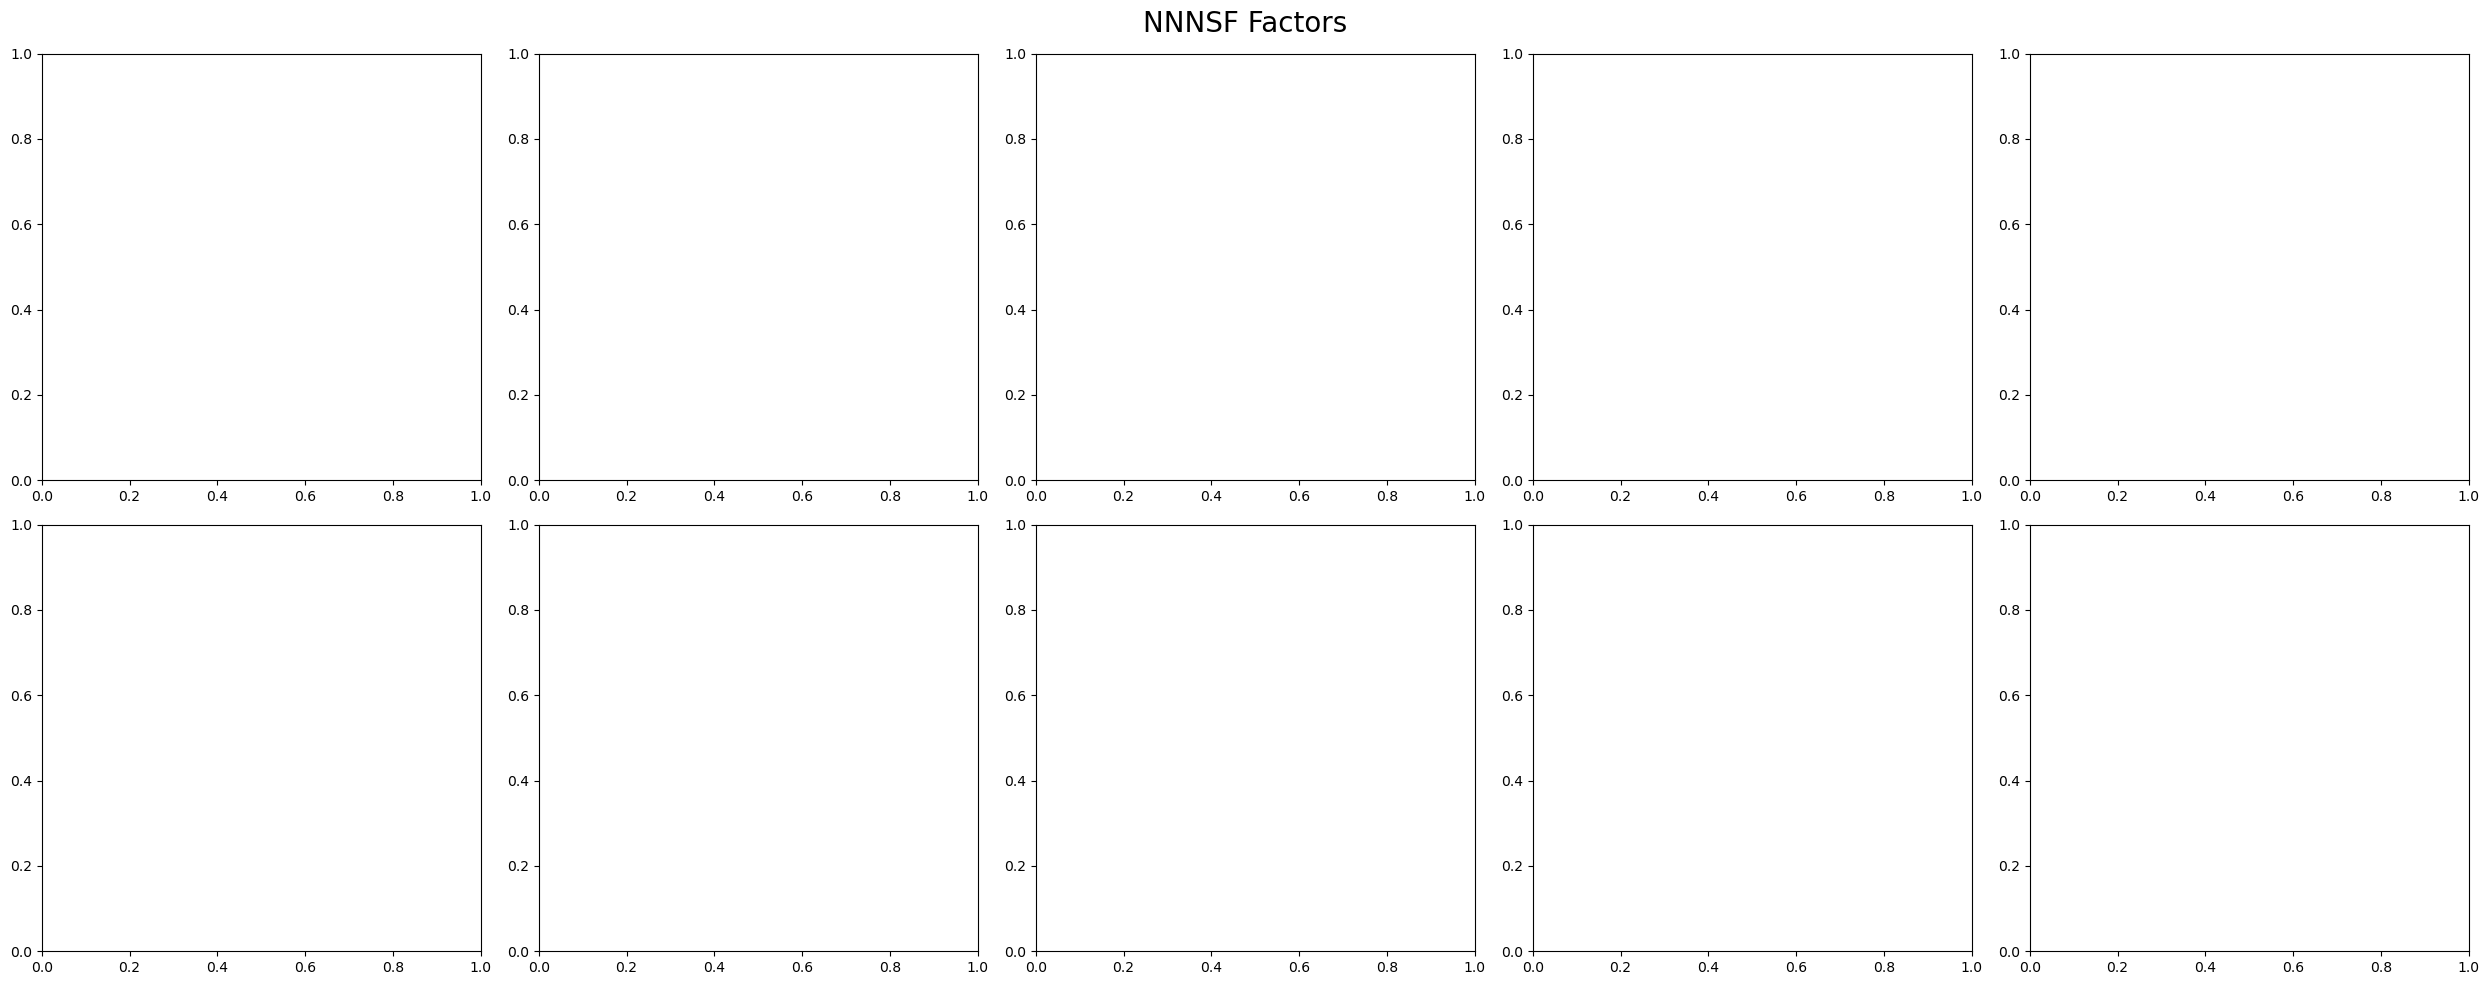

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:06<00:00, 306.35s/it]


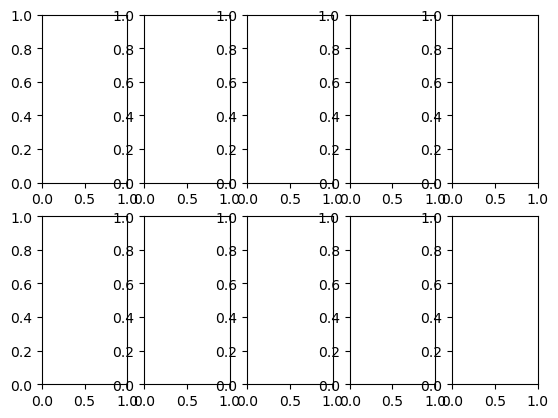

In [9]:
main()